# Planarian lineages: preprocessing using Scanpy

Here, we demonstrate how to reproduce Seurat's preprocessing using [Scanpy](https://github.com/theislab/scanpy).

All necessary files can be downloaded from the download section on https://shiny.mdc-berlin.de/psca/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/planaria_pp.h5ad'

scanpy==1.0.4 anndata==0.5.10 numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


## Preprocessing

In [2]:
adata = sc.read('./data/reg.dge.txt', cache=True).T

... reading from cache file ./cache/data-reg.dge.h5ad


In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
adata = adata[adata.obs['n_genes'] < 2500, :]

In [5]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

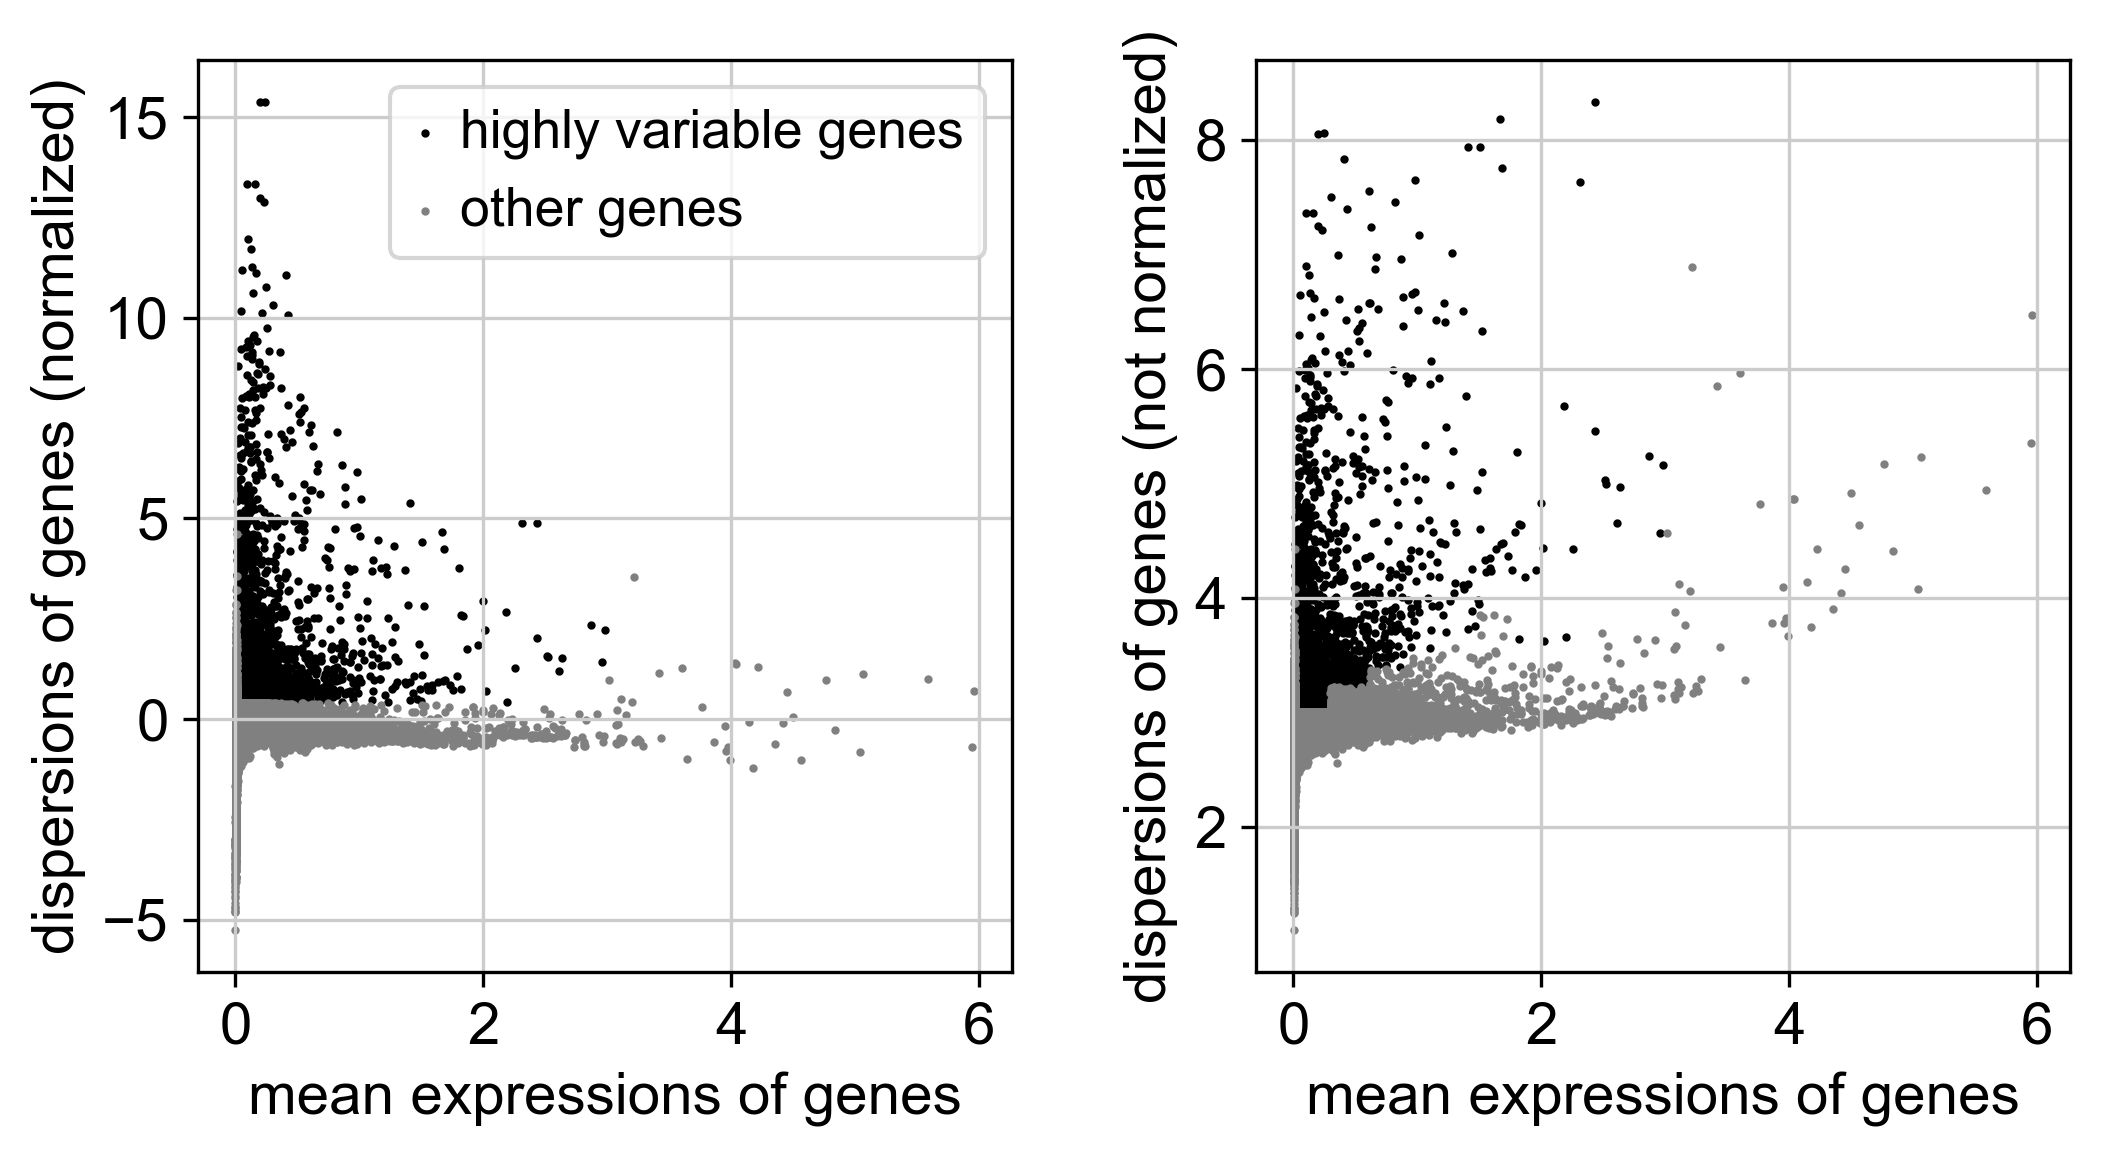

In [6]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.01, max_mean=3, min_disp=0.4)
sc.pl.filter_genes_dispersion(filter_result)

In [7]:
adata = adata[:, filter_result.gene_subset]

In [8]:
sc.pp.log1p(adata)

In [9]:
sc.pp.regress_out(adata, 'n_counts')

regressing out n_counts
    finished (0:00:46.92)


In [10]:
sc.pp.scale(adata, max_value=10)

## PCA

In [11]:
sc.pp.pca(adata)

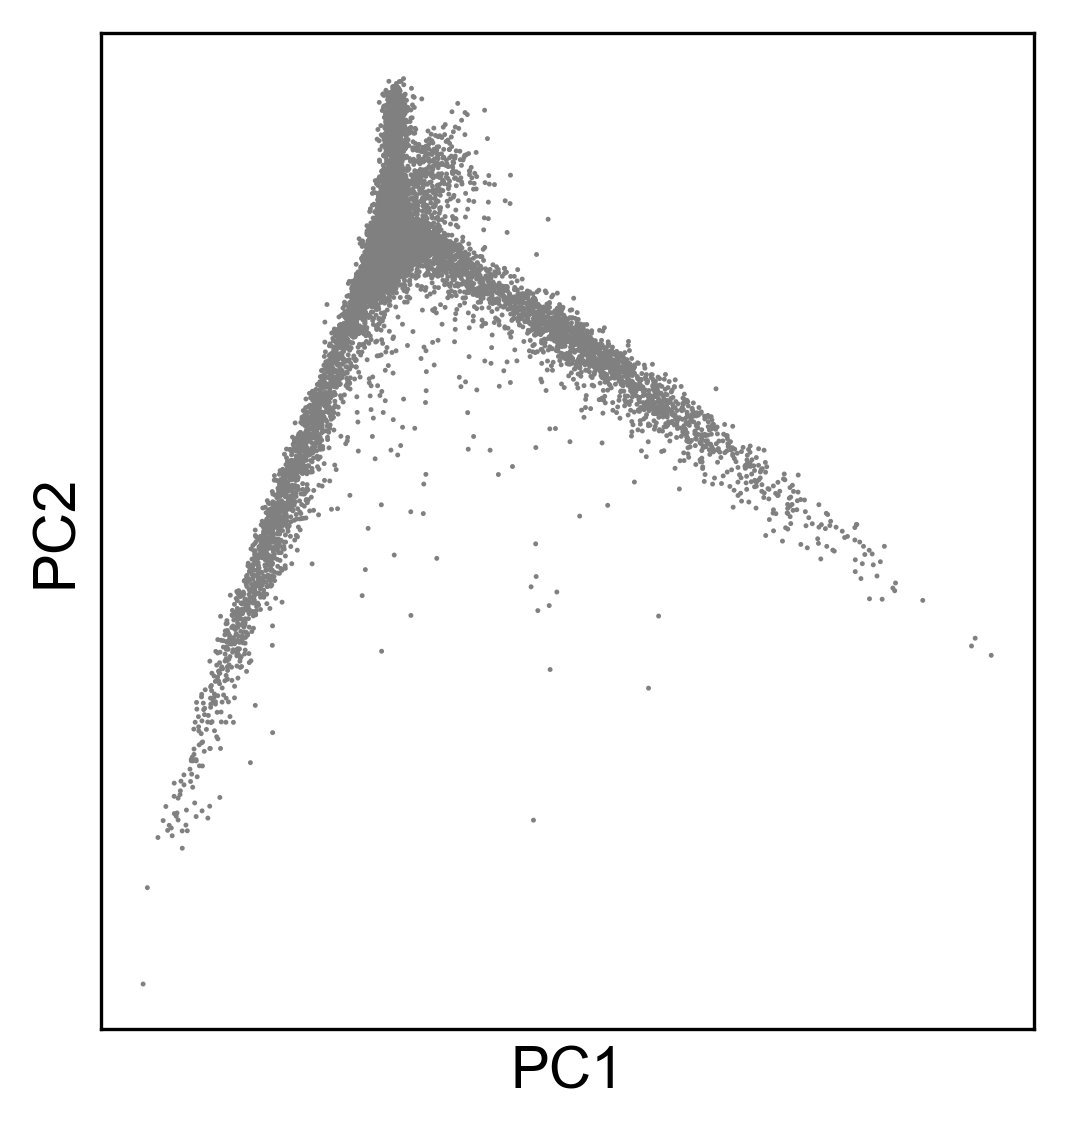

In [12]:
adata.obsm['X_pca'][:, 1] *= -1  # to match Seurat
sc.pl.pca_scatter(adata)

There are small differences between the PCA obtained with Seurat and the PCA obtained with Scanpy in the higher components. Even though this makes no qualitative difference, we use Seurat's PCA for the exact reproduction of the results of the paper.

In [13]:
X_pca_seurat = np.loadtxt('./data/R_pca_seurat.txt').astype('float32')
print(np.sum(adata.obsm['X_pca'] - X_pca_seurat))

-0.00227356


In [14]:
adata.obsm['X_pca'] = X_pca_seurat

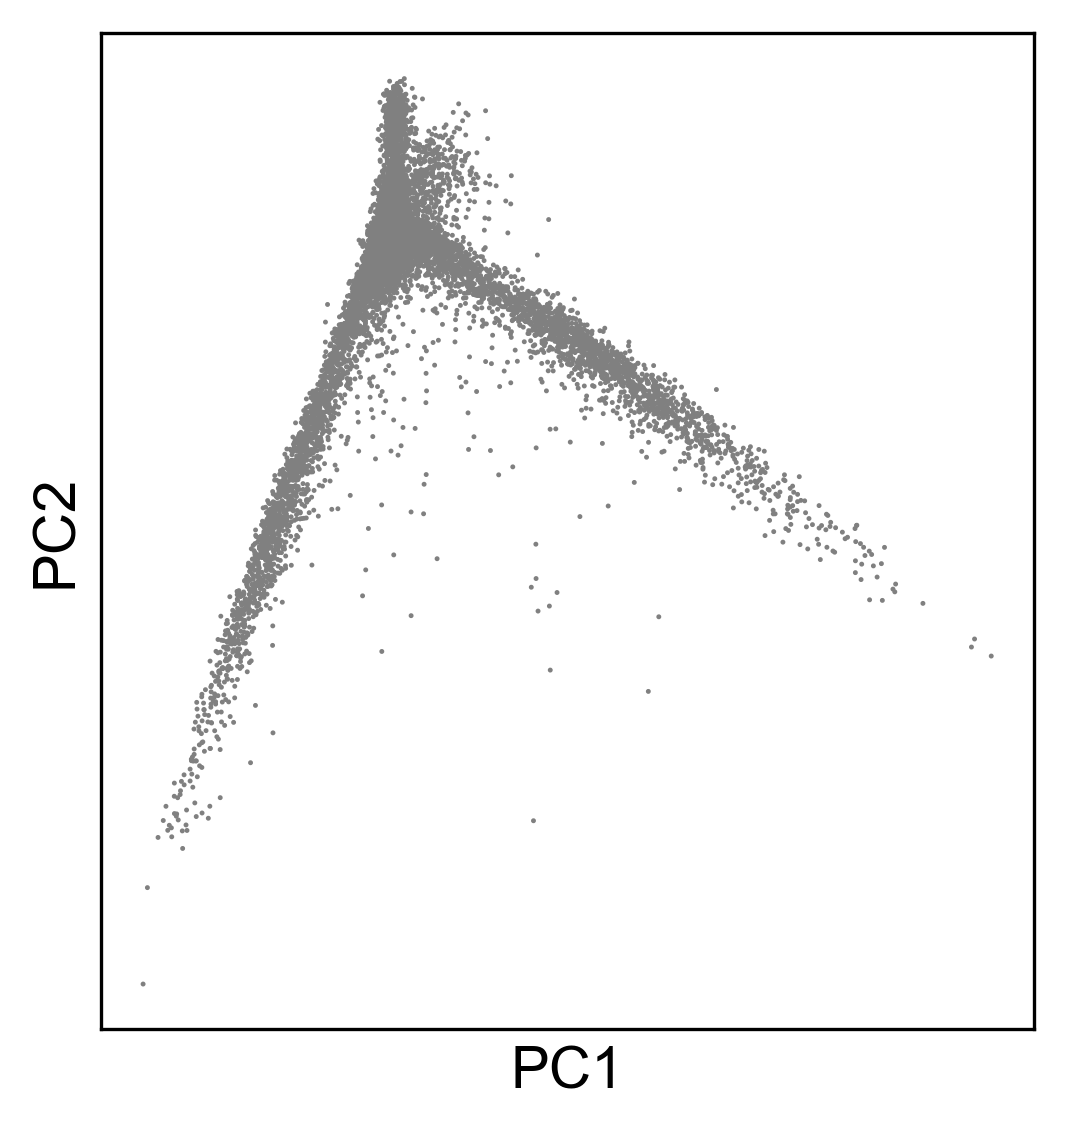

In [15]:
sc.pl.pca_scatter(adata)

In [16]:
adata.write(results_file)

## Clustering

In [17]:
adata = sc.read(results_file)

In [18]:
sc.pp.neighbors(adata, n_neighbors=30)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:17.32)


In [19]:
sc.tl.louvain(adata, resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:07.96)


Add Seurat's clustering as annotation - this is the one we eventually use.

In [20]:
adata.obs['clusters'] = np.genfromtxt('./data/R_annotation.txt', delimiter=',', dtype=str)
sc.utils.sanitize_anndata(adata)

... storing 'clusters' as categorical


In [21]:
adata.obs['clusters'].cat.reorder_categories([
    'early epidermal progenitors', 'activated early epidermal progenitors',
    'epidermal neoblasts', 'epidermis', 'epidermis DVb',
    'epidermis DVb neoblast', 'glia', 'phagocytes', 'goblet cells',
    'psd+ cells', 'gut progenitors', 'late epidermal progenitors 1',
    'late epidermal progenitors 2', 'muscle body', 'muscle pharynx',
    'muscle progenitors', 'neoblast 1', 'neoblast 2', 'neoblast 3',
    'neoblast 4', 'neoblast 5', 'neoblast 6', 'neoblast 7', 'neoblast 8',
    'neoblast 9', 'neoblast 10', 'neoblast 11', 'neoblast 12',
    'neoblast 13', 'ChAT neurons 1', 'ChAT neurons 2', 'GABA neurons',
    'otf+ cells 1', 'otf+ cells 2', 'spp-11+ neurons', 'npp-18+ neurons',
    'cav-1+ neurons', 'neural progenitors', 'pharynx cell type progenitors',
    'pgrn+ parenchymal cells', 'ldlrr-1+ parenchymal cells',
    'psap+ parenchymal cells', 'aqp+ parenchymal cells',
    'parenchymal progenitors', 'pharynx cell type', 'pigment',
    'protonephridia', 'secretory 1', 'secretory 2', 'secretory 3',
    'secretory 4'], inplace=True)

In [22]:
colors = pd.read_csv('./data/colors_dataset.txt', header=None, sep='\t')
# transform to dict where keys are cluster names
colors = {k: c for k, c in colors.values}
adata.uns['clusters_colors'] = [colors[clus] for clus in adata.obs['clusters'].cat.categories]

In [23]:
adata.write(results_file)

## tSNE

In [24]:
adata = sc.read(results_file)

In [25]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:03:59.71)


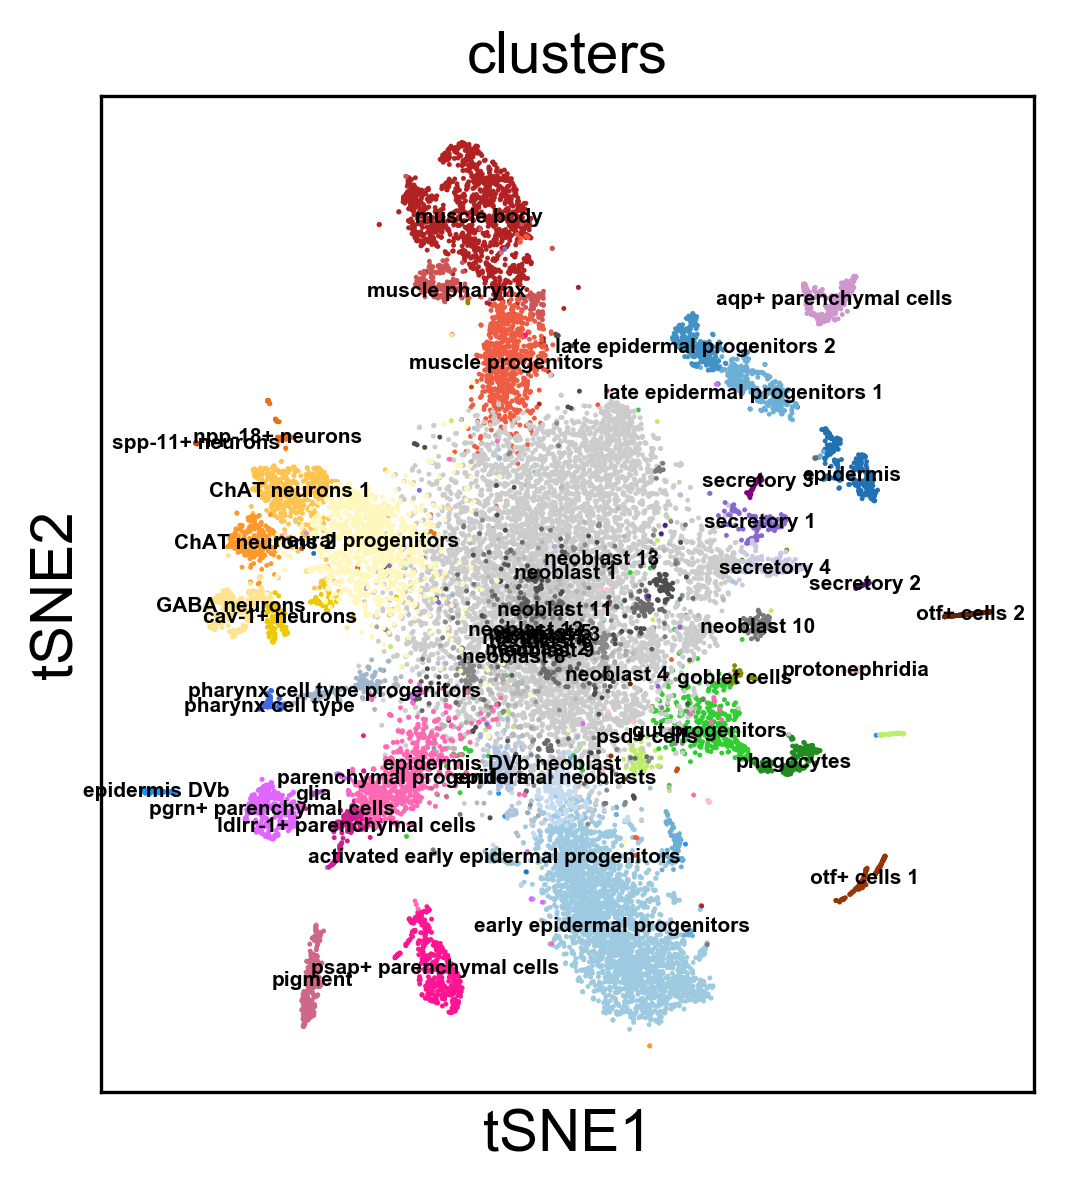

In [26]:
sc.pl.tsne(adata, color='clusters', legend_loc='on data', legend_fontsize=5)

From the following tSNE, it's evident that the default clustering is much too coarse-grained. One would need to recluster certain regions.

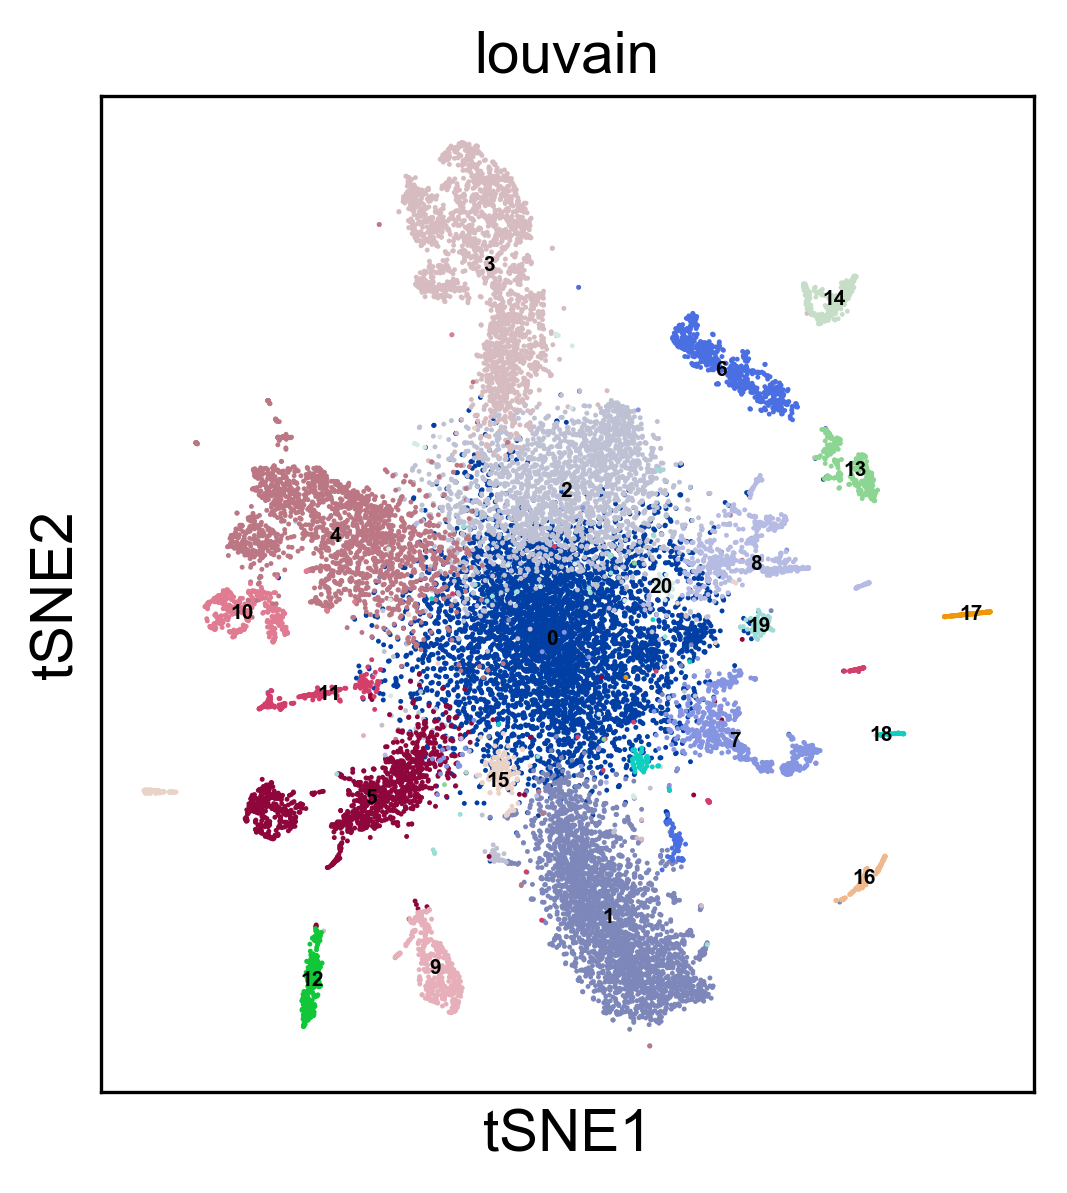

In [27]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', legend_fontsize=5)

In [28]:
adata.write(results_file)

## PAGA

In [29]:
adata = sc.read(results_file)

In [30]:
sc.tl.paga(adata, groups='clusters')

running partition-based graph abstraction (PAGA)
    initialized `.distances` `.connectivities` 
    finished (0:00:01.64)


In [31]:
paga_plot_params = dict(
    legend_fontsize=5,
    solid_edges='confidence_tree',
    dashed_edges='confidence',
    root='neoblast 1',
    layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

saving figure to file ./figures/paga_compare_100percent.png


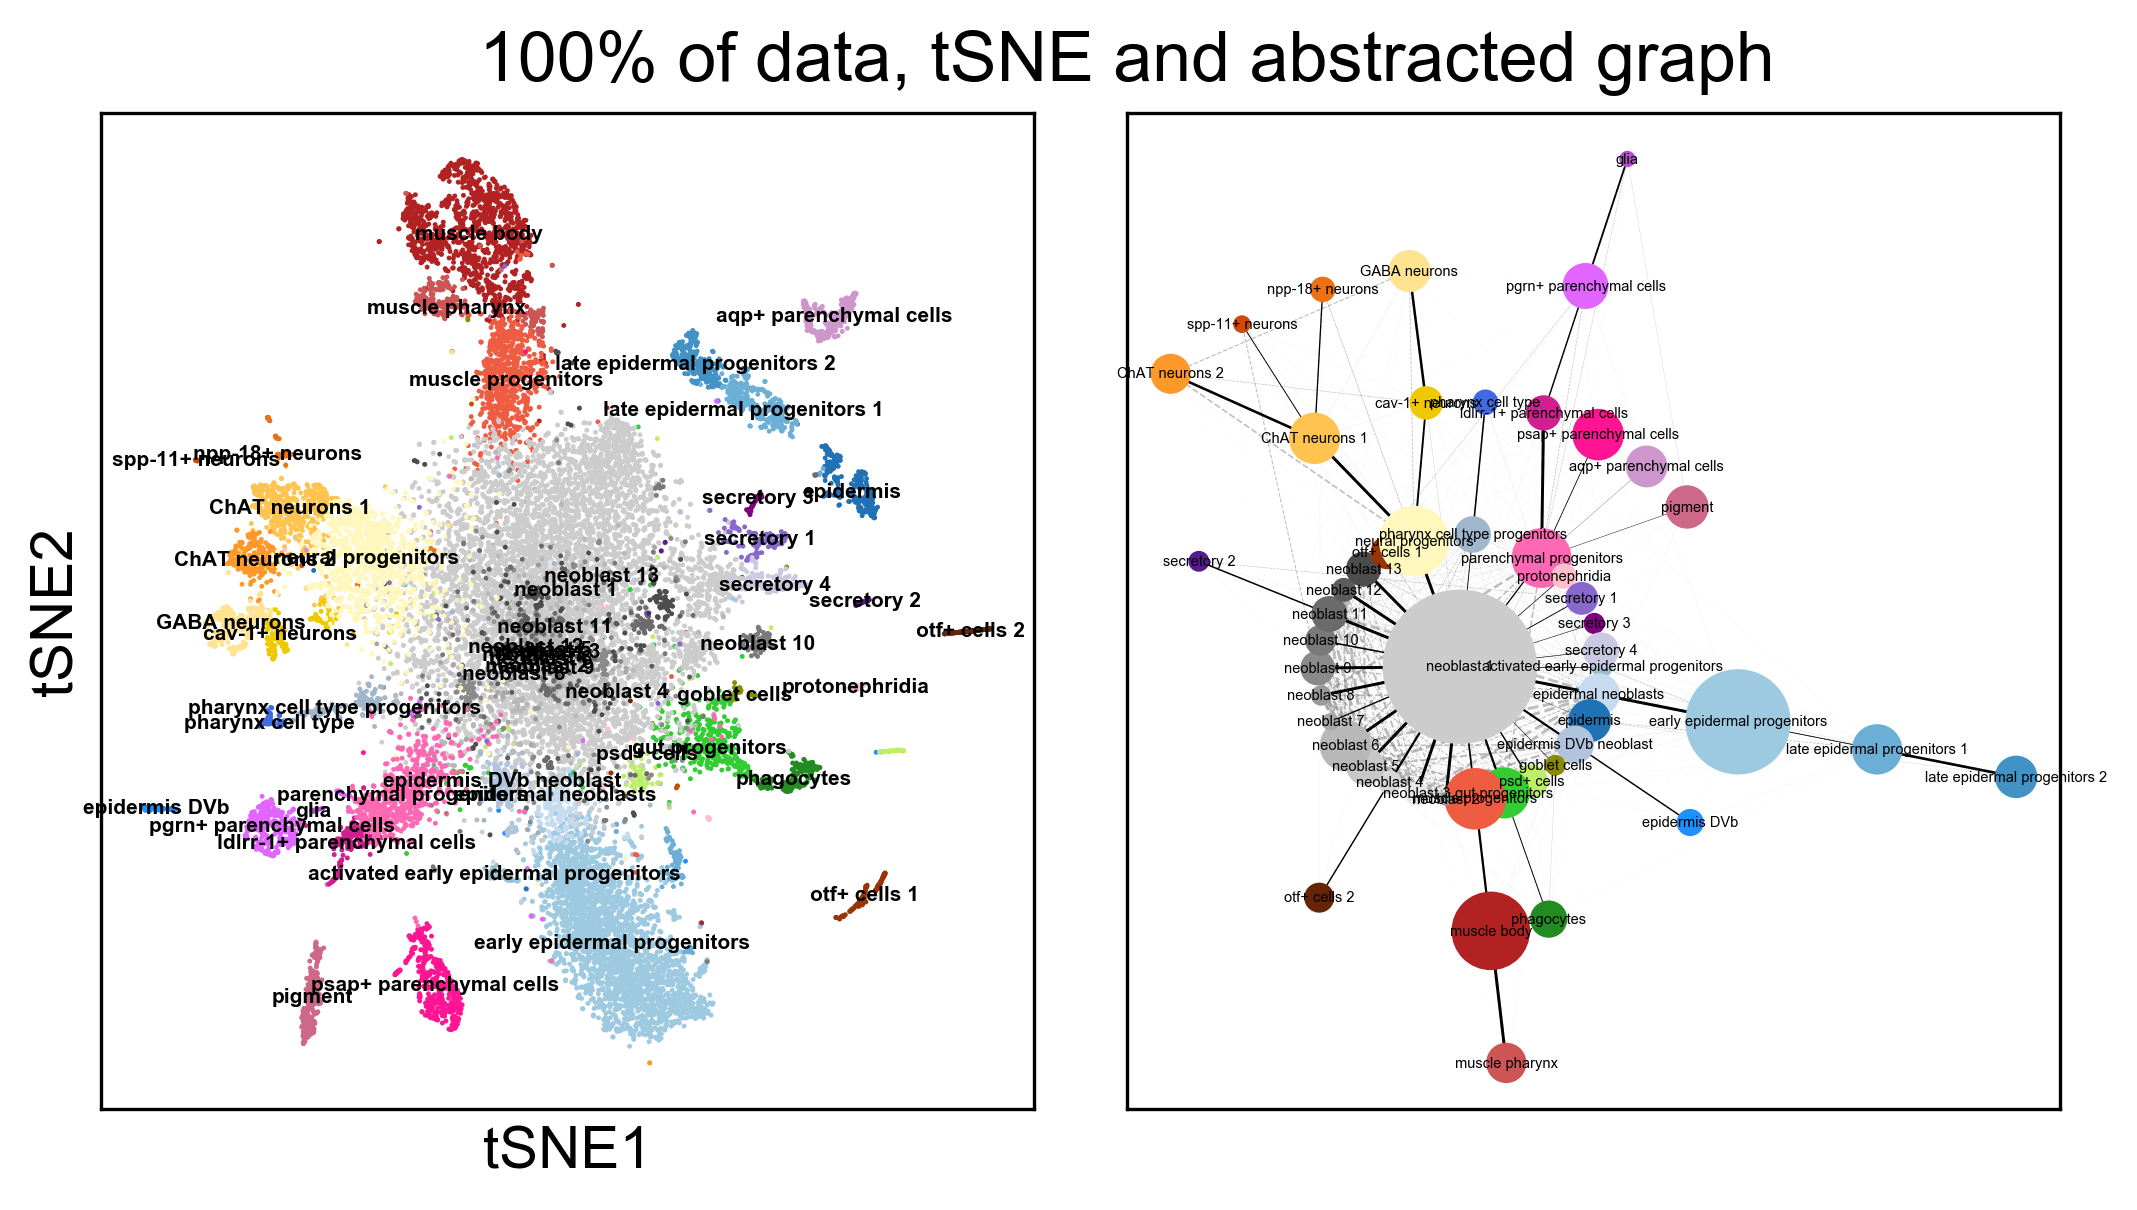

In [32]:
sc.pl.paga_compare(adata, title='100% of data, tSNE and abstracted graph', **paga_plot_params, save='_100percent')

In [33]:
adata.write(results_file)

## Pseudotime

Compute pseudotime: this is diffusion pseudotime of [Haghverdi *et al.* (2016)](https://doi.org/10.1038/nmeth.3971) in the extended implementation of PAGA [Wolf *et al.* (2017)](https://doi.org/10.1101/208819).

In [34]:
adata.uns['iroot'] = 6  # root cell (the first neoblast in the file)

In [35]:
adata = sc.read(results_file)
# the following is not necessary for an almost-reproduction of the original pseudotime
# if you want the same results, recompute the graph with connectivities from method='gauss'
# sc.pp.neighbors(adata, method='gauss', n_neighbors=30)  

In [36]:
sc.tl.dpt(adata)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [ 1.            0.9976943731  0.9965093136  0.9964524508  0.9959484339
      0.9953794479  0.9947217107  0.9939476252  0.9936671853  0.9928948879]
    finished (0:00:01.86)


In [37]:
adata

AnnData object with n_obs × n_vars = 21612 × 4900 
    obs: 'n_genes', 'n_counts', 'louvain', 'clusters'
    var: 'n_cells'
    uns: 'clusters_colors', 'clusters_sizes', 'louvain', 'louvain_colors', 'neighbors', 'paga', 'pca', 'diffmap_evals'
    obsm: 'X_pca', 'X_tsne', 'X_diffmap'
    varm: 'PCs'

In [38]:
adata.write(results_file)